✅ All libraries imported successfully
📊 Data Loaded:
   Training samples: 512
   Test samples: 128
   Features: 16
   Target range: [63.37, 80.80]
🔧 Model Configurations:
   ✓ KNN
   ✓ DECISION_TREE
   ✓ RANDOM_FOREST
   ✓ SVR
   ✓ RIDGE
TRAINING BASE MODELS WITH 10-FOLD CROSS-VALIDATION

🔄 Training KNN...
   ✅ KNN Trained
      10-Fold CV RMSE: 2.4078 ± 0.9474
      Test RMSE: 2.3121
      Test MAE: 1.7176
      Test R²: 0.0545
      Best Params: {'n_neighbors': 9, 'weights': 'distance'}

🔄 Training DECISION_TREE...
   ✅ DECISION_TREE Trained
      10-Fold CV RMSE: 2.3850 ± 0.9093
      Test RMSE: 2.3090
      Test MAE: 1.7353
      Test R²: 0.0569
      Best Params: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

🔄 Training RANDOM_FOREST...
   ✅ RANDOM_FOREST Trained
      10-Fold CV RMSE: 2.2987 ± 0.9258
      Test RMSE: 2.1430
      Test MAE: 1.6199
      Test R²: 0.1877
      Best Params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}

🔄 Training S

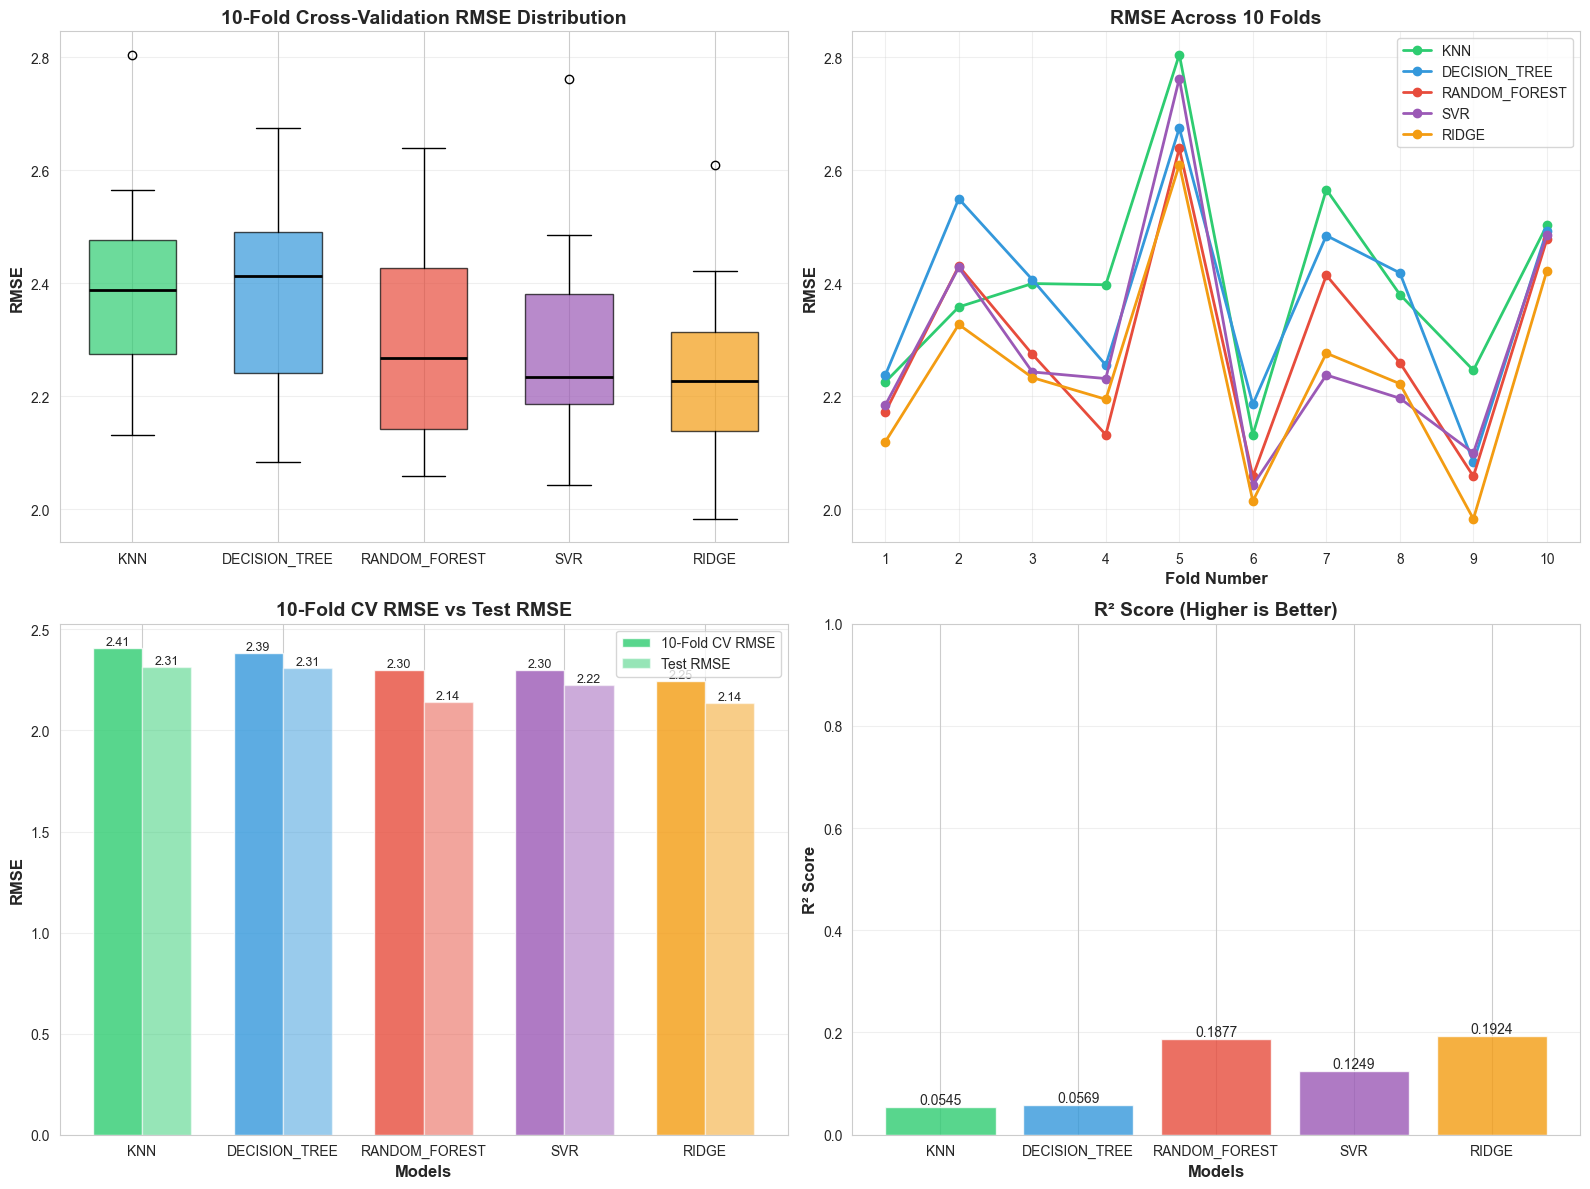


MODEL PERFORMANCE SUMMARY


,Model,CV RMSE,Test RMSE,Test MAE,Test R²
0,KNN,2.4078,2.3121,1.7176,0.0545
1,DECISION_TREE,2.3850,2.3090,1.7353,0.0569
2,RANDOM_FOREST,2.2987,2.1430,1.6199,0.1877
3,SVR,2.2997,2.2243,1.6518,0.1249
4,RIDGE,2.2469,2.1368,1.5945,0.1924



Best Model: RIDGE
   Test RMSE: 2.1368
   Test R²: 0.1924

DETAILED TEST RESULTS

KNN
   Test RMSE: 2.3121
   Test MAE:  1.7176
   Test R²:   0.0545
   10-Fold CV RMSE: 2.4078 ± 0.8976
   Mean Residual: 0.0799
   Std Residual:  2.3107

DECISION_TREE
   Test RMSE: 2.3090
   Test MAE:  1.7353
   Test R²:   0.0569
   10-Fold CV RMSE: 2.3850 ± 0.8268
   Mean Residual: 0.2724
   Std Residual:  2.2929

RANDOM_FOREST
   Test RMSE: 2.1430
   Test MAE:  1.6199
   Test R²:   0.1877
   10-Fold CV RMSE: 2.2987 ± 0.8571
   Mean Residual: 0.2007
   Std Residual:  2.1336

SVR
   Test RMSE: 2.2243
   Test MAE:  1.6518
   Test R²:   0.1249
   10-Fold CV RMSE: 2.2997 ± 0.9696
   Mean Residual: 0.2434
   Std Residual:  2.2110

RIDGE
   Test RMSE: 2.1368
   Test MAE:  1.5945
   Test R²:   0.1924
   10-Fold CV RMSE: 2.2469 ± 0.8088
   Mean Residual: 0.1439
   Std Residual:  2.1319

TEST PREDICTIONS ANALYSIS

KNN
   Total Test Samples: 128
   Mean Absolute Error: 1.7176
   Median Absolute Error: 1.2308
   

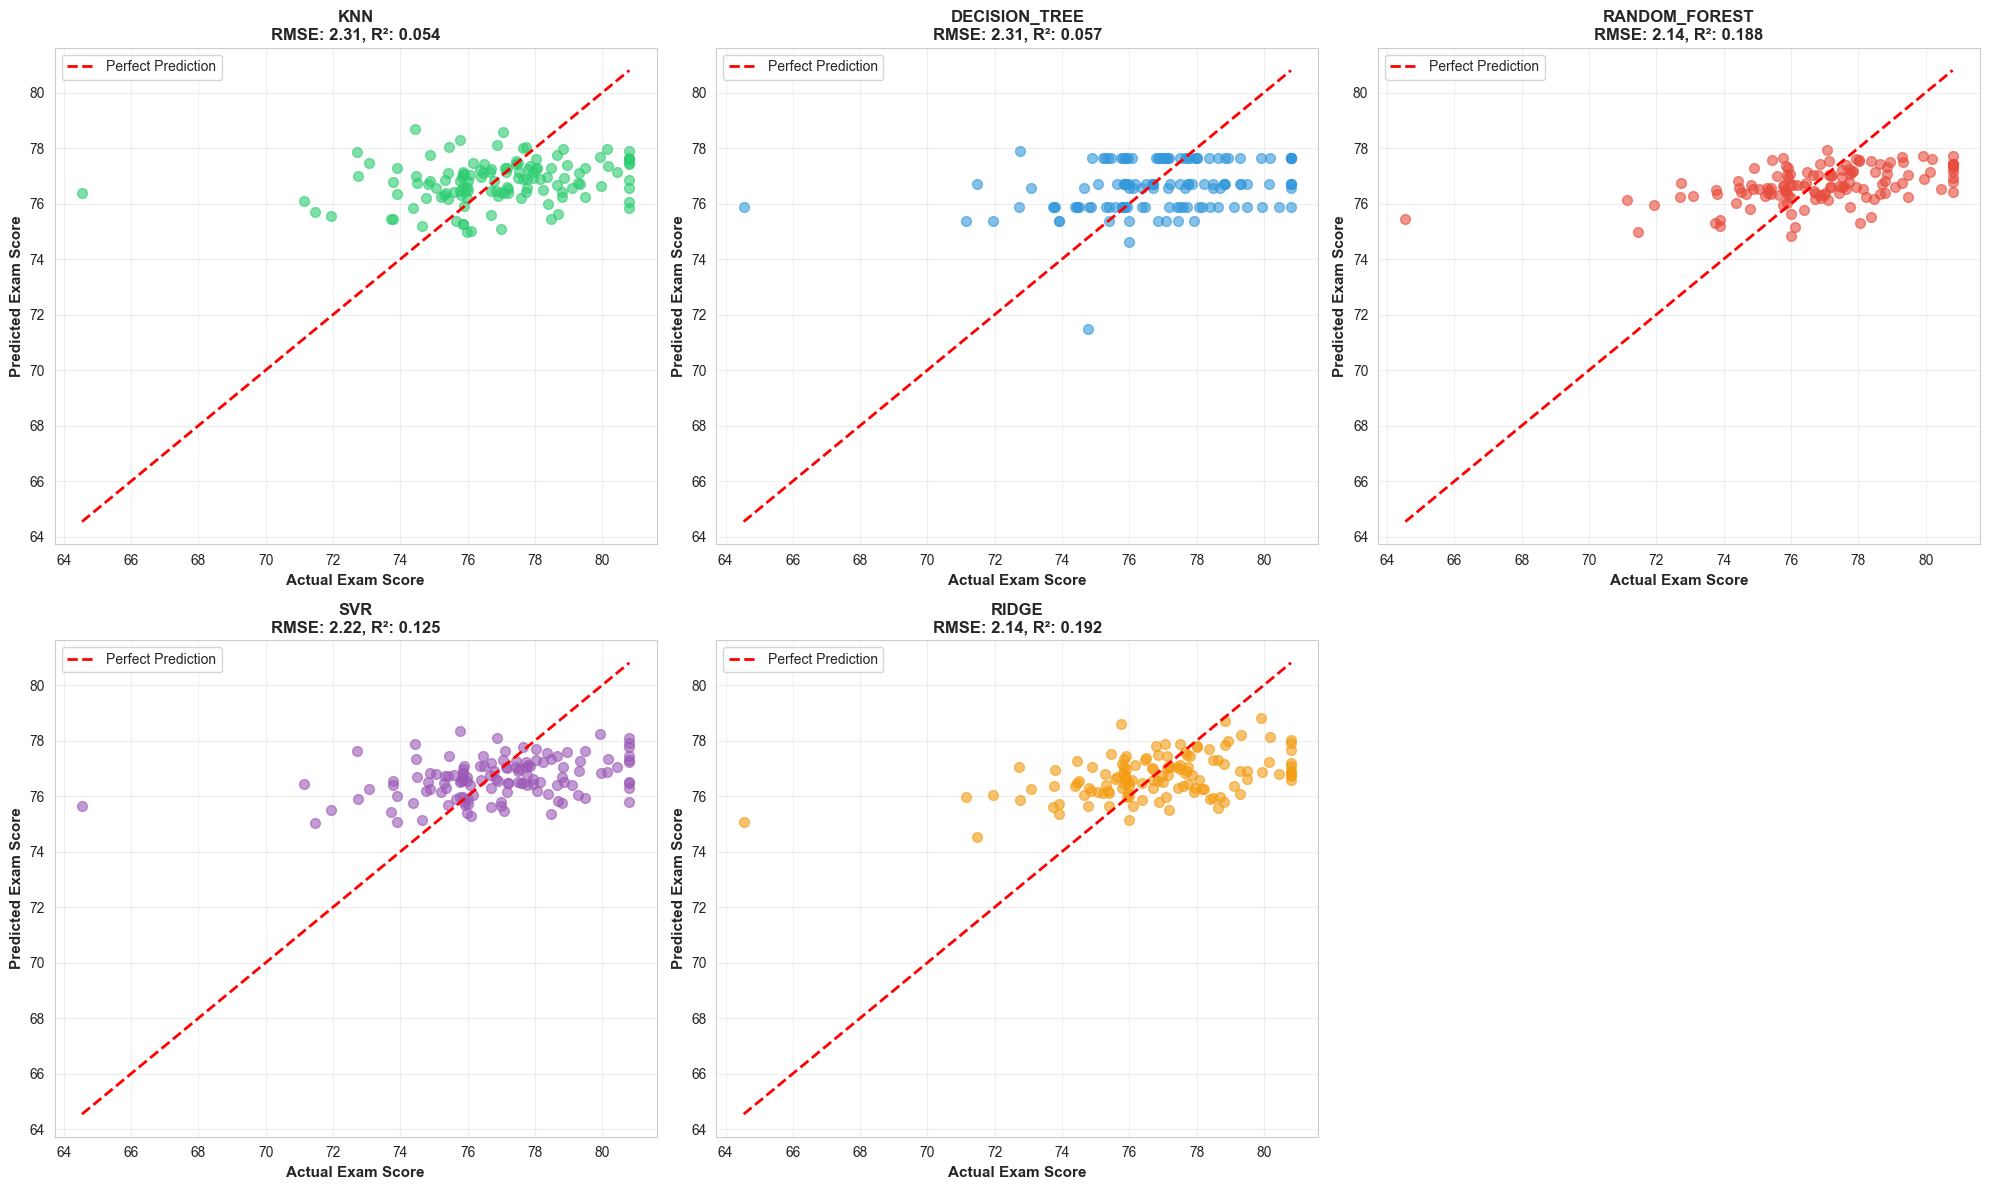

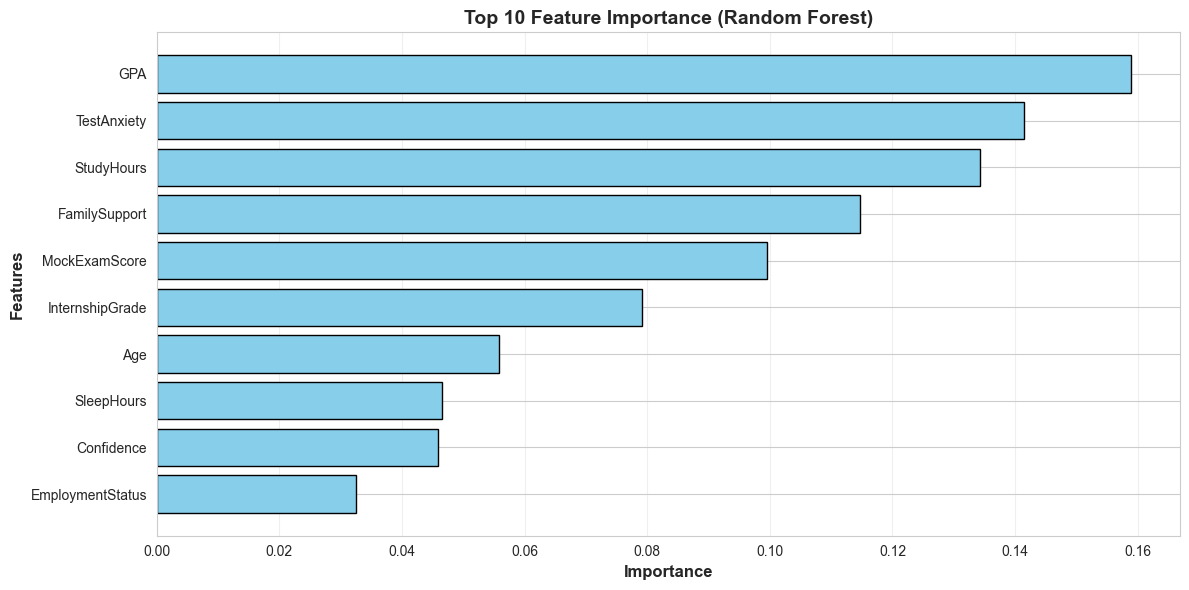


📊 Feature Importance:


,Feature,Importance
9,GPA,0.158950
7,TestAnxiety,0.141479
4,StudyHours,0.134198
14,FamilySupport,0.114768
8,MockExamScore,0.099466
11,InternshipGrade,0.079126
3,Age,0.055867
5,SleepHours,0.046448
6,Confidence,0.045841
2,EmploymentStatus,0.032481



💾 Models saved to saved_base_models/
✅ BASE MODELS TRAINING COMPLETE!

Preprocessor saved to ../saved_base_models/


In [ ]:
# Cell 1: Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All libraries imported successfully")

# Cell 2: Preprocessed Data
X_train = np.load('../regression_processed_data/X_train.npy')
X_test = np.load('../regression_processed_data/X_test.npy')
y_train = np.load('../regression_processed_data/y_train.npy')
y_test = np.load('../regression_processed_data/y_test.npy')

print(f"📊 Data Loaded:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

# Cell 3: Define Model Configurations
model_configs = {
    'knn': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10]
        }
    },
        'svr': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.01, 0.1, 0.2],
            'kernel': ['rbf']
        }
    },
    'ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    }
}

print("🔧 Model Configurations:")
for name in model_configs.keys():
    print(f"   ✓ {name.upper()}")

# Cell 4: Train Models with 10-Fold CV
from sklearn.model_selection import KFold

results = {}
cv = KFold(n_splits=10, shuffle=True, random_state=42)

print("=" * 70)
print("TRAINING BASE MODELS WITH 10-FOLD CROSS-VALIDATION")
print("=" * 70)

for name, config in model_configs.items():
    print(f"\n🔄 Training {name.upper()}...")
    
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    cv_results = grid_search.cv_results_
    best_index = grid_search.best_index_
    
    fold_scores = []
    for fold_idx in range(10):
        fold_key = f'split{fold_idx}_test_score'
        fold_scores.append(-cv_results[fold_key][best_index])
    
    cv_mean = np.mean(fold_scores)
    cv_std = np.std(fold_scores)
    cv_min = np.min(fold_scores)
    cv_max = np.max(fold_scores)
    
    cv_rmse = np.sqrt(cv_mean)
    
    y_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': best_model,
        'cv_mse_mean': cv_mean,
        'cv_mse_std': cv_std,
        'cv_mse_min': cv_min,
        'cv_mse_max': cv_max,
        'cv_rmse': cv_rmse,
        'cv_10fold_scores': fold_scores,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_pred': y_pred,
        'best_params': grid_search.best_params_
    }
    
    print(f"   ✅ {name.upper()} Trained")
    print(f"      10-Fold CV RMSE: {cv_rmse:.4f} ± {np.sqrt(cv_std):.4f}")
    print(f"      Test RMSE: {test_rmse:.4f}")
    print(f"      Test MAE: {test_mae:.4f}")
    print(f"      Test R²: {test_r2:.4f}")
    print(f"      Best Params: {grid_search.best_params_}")

# Cell 5: Visualize 10-Fold CV Results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())
colors = ['#2ecc71', '#3498db', '#e74c3c',  '#9b59b6', '#f39c12']

# Plot 1: Box plot of 10-fold scores (RMSE)
fold_data = []
for name in model_names:
    for fold_idx, mse in enumerate(results[name]['cv_10fold_scores'], 1):
        fold_data.append({
            'Model': name.upper(),
            'Fold': fold_idx,
            'RMSE': np.sqrt(mse)
        })

fold_df = pd.DataFrame(fold_data)

box_positions = []
for idx, name in enumerate(model_names):
    model_data = fold_df[fold_df['Model'] == name.upper()]['RMSE']
    bp = axes[0, 0].boxplot([model_data], positions=[idx], widths=0.6,
                            patch_artist=True,
                            boxprops=dict(facecolor=colors[idx], alpha=0.7),
                            medianprops=dict(color='black', linewidth=2))
    box_positions.append(idx)

axes[0, 0].set_xticks(box_positions)
axes[0, 0].set_xticklabels([name.upper() for name in model_names])
axes[0, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0, 0].set_title('10-Fold Cross-Validation RMSE Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Line plot showing each fold's performance
for idx, name in enumerate(model_names):
    fold_rmse = [np.sqrt(mse) for mse in results[name]['cv_10fold_scores']]
    axes[0, 1].plot(range(1, 11), fold_rmse, marker='o', linewidth=2,
                   label=name.upper(), color=colors[idx])

axes[0, 1].set_xlabel('Fold Number', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_title('RMSE Across 10 Folds', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(1, 11))

# Plot 3: CV RMSE vs Test RMSE comparison
x = np.arange(len(model_names))
width = 0.35

cv_rmse_values = [results[name]['cv_rmse'] for name in model_names]
test_rmse_values = [results[name]['test_rmse'] for name in model_names]

bars1 = axes[1, 0].bar(x - width/2, cv_rmse_values, width, label='10-Fold CV RMSE',
                       color=colors, alpha=0.8)
bars2 = axes[1, 0].bar(x + width/2, test_rmse_values, width, label='Test RMSE',
                       color=colors, alpha=0.5)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[1, 0].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[1, 0].set_title('10-Fold CV RMSE vs Test RMSE', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([name.upper() for name in model_names])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: R² Score comparison
r2_scores = [results[name]['test_r2'] for name in model_names]

bars = axes[1, 1].bar([name.upper() for name in model_names], r2_scores,
                      color=colors, alpha=0.8)

for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10)

axes[1, 1].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Cell 6: Performance Summary Table
summary_data = []
for name in model_names:
    summary_data.append({
        'Model': name.upper(),
        'CV RMSE': f"{results[name]['cv_rmse']:.4f}",
        'Test RMSE': f"{results[name]['test_rmse']:.4f}",
        'Test MAE': f"{results[name]['test_mae']:.4f}",
        'Test R²': f"{results[name]['test_r2']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)
display(summary_df)

best_model_name = min(results.items(), key=lambda x: x[1]['test_rmse'])[0]
print(f"\nBest Model: {best_model_name.upper()}")
print(f"   Test RMSE: {results[best_model_name]['test_rmse']:.4f}")
print(f"   Test R²: {results[best_model_name]['test_r2']:.4f}")

print("\n" + "=" * 70)
print("DETAILED TEST RESULTS")
print("=" * 70)

for name in model_names:
    y_pred = results[name]['y_pred']
    rmse = results[name]['test_rmse']
    mae = results[name]['test_mae']
    r2 = results[name]['test_r2']
    
    print(f"\n{name.upper()}")
    print(f"   Test RMSE: {rmse:.4f}")
    print(f"   Test MAE:  {mae:.4f}")
    print(f"   Test R²:   {r2:.4f}")
    print(f"   10-Fold CV RMSE: {results[name]['cv_rmse']:.4f} ± {results[name]['cv_mse_std']:.4f}")
    
    residuals = y_test - y_pred
    print(f"   Mean Residual: {np.mean(residuals):.4f}")
    print(f"   Std Residual:  {np.std(residuals):.4f}")

# Cell 6.5: Detailed Test Predictions Analysis
print("\n" + "=" * 70)
print("TEST PREDICTIONS ANALYSIS")
print("=" * 70)

for name in model_names:
    y_pred = results[name]['y_pred']
    
    prediction_details = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'Absolute_Error': np.abs(y_test - y_pred),
        'Percent_Error': np.abs((y_test - y_pred) / y_test) * 100
    })
    
    print(f"\n{name.upper()}")
    print(f"   Total Test Samples: {len(y_test)}")
    print(f"   Mean Absolute Error: {prediction_details['Absolute_Error'].mean():.4f}")
    print(f"   Median Absolute Error: {prediction_details['Absolute_Error'].median():.4f}")
    print(f"   Max Error: {prediction_details['Absolute_Error'].max():.4f}")
    print(f"   Min Error: {prediction_details['Absolute_Error'].min():.4f}")
    
    print(f"\n   First 10 predictions:")
    print(prediction_details.head(10).to_string(index=False))
    
    csv_file = f'../saved_base_models/{name}_test_predictions.csv'
    prediction_details.to_csv(csv_file, index=False)
    print(f"\n   Saved detailed predictions: {csv_file}")

# Cell 7: Prediction vs Actual Plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, name in enumerate(model_names):
    y_pred = results[name]['y_pred']
    
    # Scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=50, color=colors[idx])
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                   'r--', linewidth=2, label='Perfect Prediction')
    
    # Metrics
    rmse = results[name]['test_rmse']
    r2 = results[name]['test_r2']
    
    axes[idx].set_xlabel('Actual Exam Score', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Predicted Exam Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{name.upper()}\nRMSE: {rmse:.2f}, R²: {r2:.3f}',
                       fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

axes[5].axis('off')

plt.tight_layout()
plt.show()

# Cell 8: Feature Importance
if 'random_forest' in results:
    feature_names = json.load(open('../regression_processed_data/feature_names.json'))
    
    rf_model = results['random_forest']['model']
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['Feature'][:10], 
             feature_importance['Importance'][:10],
             color='skyblue', edgecolor='black')
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Top 10 Feature Importance (Random Forest)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Feature Importance:")
    display(feature_importance)

# Cell 9: Save Models
os.makedirs('../saved_base_models', exist_ok=True)

for name, data in results.items():
    joblib.dump(data['model'], f'../saved_base_models/{name}_model.pkl')

print("\n💾 Models saved to saved_base_models/")
print("✅ BASE MODELS TRAINING COMPLETE!")

# Cell 10: Create and Save Preprocessor
import joblib
import os

models_path = os.path.abspath('..')
if models_path not in sys.path:
    sys.path.insert(0, models_path)

# Import from the correct module path
from regression_preprocessor import RegressionPreprocessor

label_encoders = joblib.load('../regression_processed_data/label_encoders.pkl')
imputer = joblib.load('../regression_processed_data/imputer.pkl')
scaler = joblib.load('../regression_processed_data/scaler.pkl')
feature_names = json.load(open('../regression_processed_data/feature_names.json'))

preprocessor = RegressionPreprocessor(imputer, label_encoders, scaler)

joblib.dump(preprocessor, '../saved_base_models/preprocessor.pkl')
joblib.dump(feature_names, '../saved_base_models/feature_names.pkl')

print("\nPreprocessor saved to ../saved_base_models/")
